In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from tools.utils.sqlite_utils import create_connection

import pandas as pd
import ast
import re
import pickle
import tiktoken

conn = create_connection('../dataset/CVEfixes_v1.0.8/Data/DB.db')

In [2]:
query = f"""
SELECT
        f.file_change_id,
        f.programming_language,
        cwe.cwe_id,
        f.code_after AS non_vuln_code,
        f.code_before AS vuln_code,
        cwe.description AS cwe_description,
        f.diff_parsed,
        cve.description AS cve_description,
        f.token_count
FROM file_change f
        INNER JOIN fixes
                ON f.hash = fixes.hash
        INNER JOIN cve
                ON fixes.cve_id = cve.cve_id
        INNER JOIN cwe_classification
                ON cve.cve_id = cwe_classification.cve_id
        INNER JOIN cwe
                ON cwe_classification.cwe_id = cwe.cwe_id
WHERE
        f.num_lines_added>1
        AND f.num_lines_deleted>1
        AND f.programming_language IS NOT NULL
        AND cwe.cwe_id IS NOT NULL
        AND cwe.cwe_name IS NOT NULL
        AND f.code_before IS NOT NULL
        AND cwe.description IS NOT NULL
        AND f.diff_parsed IS NOT NULL
        AND cve.description IS NOT NULL
        AND f.token_count IS NOT NULL;
    """
df = pd.read_sql(query, con=conn)
print(len(df))

20117


In [3]:
langs = ["PHP", "JavaScript", "Java", "TypeScript", "Ruby", "Python"]
remove_cwe = ['NVD-CWE-noinfo', 'NVD-CWE-Other']
chosen_cwes = ['CWE-79', 'CWE-89', 'CWE-434', 'CWE-352']

def pre_processing(df):
    print(f"Initial df length: {len(df)}")

    # keep only the specified programming languages
    df = df[df['programming_language'].isin(langs)]
    print(f"After filtering programming languages: {len(df)}")

    # code diff: both add & del should exist
    df['diff_added'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['added'], axis=1)
    df['diff_deleted'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['deleted'], axis=1)
    df = df[df['diff_added'].apply(bool) & df['diff_deleted'].apply(bool)]
    print(f"After filtering diff_added & diff_deleted: {len(df)}")

    df = df.reset_index(drop=True)
    df = df.drop(columns=['diff_parsed'])

    # cve description type str -> arr
    def parse_py_literal(text):
        if not isinstance(text, str):
            return text
        try:
            return ast.literal_eval(text)
        except (SyntaxError, ValueError):
            return None

    df['cve_description'] = df['cve_description'].apply(parse_py_literal)

    # code before and after
    df = df[df['vuln_code'].notna()]
    print(f"After removing NaN vuln_code: {len(df)}")

    df = df[df['vuln_code'] != 'None']
    print(f"After removing 'None' vuln_code: {len(df)}")

    df = df[df['non_vuln_code'].notna()]
    print(f"After removing NaN non_vuln_code: {len(df)}")

    df = df[df['non_vuln_code'] != 'None']
    print(f"After removing 'None' non_vuln_code: {len(df)}")

    # remove rows where number of lines in the code is below 30
    for col in ['vuln_code', 'non_vuln_code']:
        df[f'{col}_num_lines'] = df[col].apply(
            lambda x: x.count('\n') + 1 if isinstance(x, str) else 0
        )
    df = df[df['vuln_code_num_lines'] <= 150]
    print(f"After filtering vuln_code with line numbers: {len(df)}")

    df = df[df['non_vuln_code_num_lines'] <= 150]
    print(f"After filtering non_vuln_code with line numbers: {len(df)}")

    # remove empty list in diff_deleted
    df = df[df['diff_deleted'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    print(f"After removing empty lists in diff_deleted: {len(df)}")

    # token_count should be num
    df['token_count'] = df['token_count'].apply(parse_py_literal)
    df = df.dropna(subset=['token_count'])
    df['token_count'] = pd.to_numeric(df['token_count'])

    # Function to recalculate token count
    def recalculate_token_count(text):
        encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text, disallowed_special=())) if text else 0
    df["token_count"] = df["vuln_code"].apply(recalculate_token_count)
    
    print(f"After processing token_count: {len(df)}")

    # drop the other CWEs
    df = df[df["cwe_id"].isin(chosen_cwes)]
    print(f"After removing specific CWEs: {len(df)}")


    df = df.dropna()
    print(f"Final df length after dropna: {len(df)}")

    return df

filtered_df = pre_processing(df)
print(len(filtered_df))

Initial df length: 20117
After filtering programming languages: 11213


/var/folders/rg/wn5gjnxn79s8sdtltf2gj_r00000gn/T/ipykernel_35669/2561257403.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_added'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['added'], axis=1)
/var/folders/rg/wn5gjnxn79s8sdtltf2gj_r00000gn/T/ipykernel_35669/2561257403.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_deleted'] = df.apply(lambda row: ast.literal_eval(row.diff_parsed)['deleted'], axis=1)


After filtering diff_added & diff_deleted: 11213
After removing NaN vuln_code: 11213
After removing 'None' vuln_code: 11213
After removing NaN non_vuln_code: 11213
After removing 'None' non_vuln_code: 11213
After filtering vuln_code with line numbers: 3735
After filtering non_vuln_code with line numbers: 3579
After removing empty lists in diff_deleted: 3579
After processing token_count: 3172
After removing specific CWEs: 1187
Final df length after dropna: 1187
1187


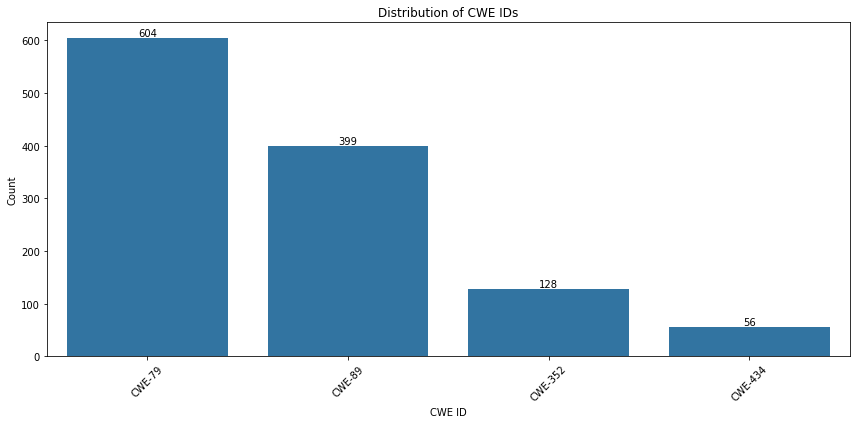

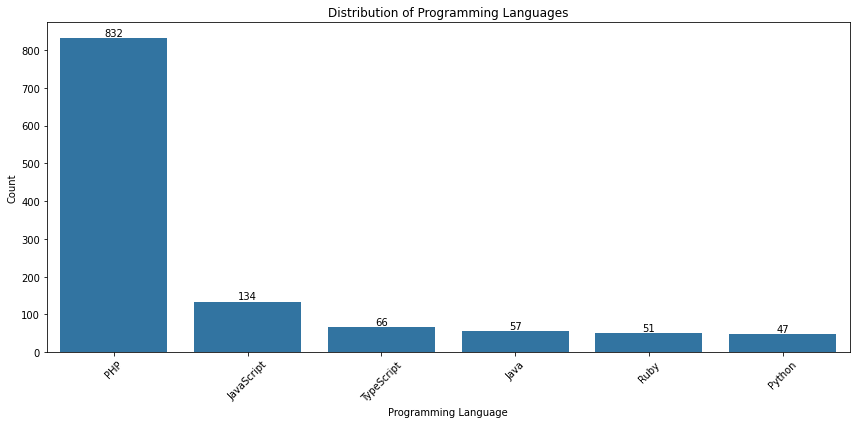

In [4]:
# Visualize the distribution of CWE IDs with graphs
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_cwe_distribution(df, test=False):
    plt.figure(figsize=(12, 6))
    cwe_counts = df['label'].value_counts() if test else df['cwe_id'].value_counts()
    ax = sns.barplot(x=cwe_counts.index, y=cwe_counts.values)
    plt.title('Distribution of CWE IDs')
    plt.xlabel('CWE ID')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add numbers on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()


def visualize_language_distribution(df):
    plt.figure(figsize=(12, 6))
    lang_counts = df['programming_language'].value_counts()
    ax = sns.barplot(x=lang_counts.index, y=lang_counts.values)
    plt.title('Distribution of Programming Languages')
    plt.xlabel('Programming Language')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Add numbers on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

visualize_cwe_distribution(filtered_df)
visualize_language_distribution(filtered_df)

In [5]:
print(filtered_df['cwe_id'].value_counts())

filtered_df['label'] = filtered_df['cwe_id']
filtered_df['code'] = filtered_df['vuln_code']

CWE-79     604
CWE-89     399
CWE-352    128
CWE-434     56
Name: cwe_id, dtype: int64


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_split(df, test_size=0.2, random_state=42):
    train_dfs = []
    test_dfs = []
    
    # Group by both programming language and CWE
    for (lang, cwe), group_df in df.groupby(['programming_language', 'cwe_id']):
        # Skip groups with 0 samples (unlikely, but safe)
        if len(group_df) == 0:
            continue
        
        # If only 1 sample, add to training to avoid test set contamination
        if len(group_df) == 1:
            train_dfs.append(group_df)
            continue
        
        # Split the group into train and test
        group_train, group_test = train_test_split(
            group_df,
            test_size=test_size,
            random_state=random_state,
            # Optional: Shuffle the group data before splitting
            shuffle=True
        )
        train_dfs.append(group_train)
        test_dfs.append(group_test)
    
    # Combine all splits
    train_set = pd.concat(train_dfs, ignore_index=True)
    test_set = pd.concat(test_dfs, ignore_index=True)
    return train_set, test_set

def stratified_split_non_vuln(df, test_size=0.2, random_state=42):
    train_dfs = []
    test_dfs = []
    
    # Group by both programming language and CWE
    for (cwe), group_df in df.groupby(['cwe_id']):
        # Skip groups with 0 samples (unlikely, but safe)
        if len(group_df) == 0:
            continue
        
        # If only 1 sample, add to training to avoid test set contamination
        if len(group_df) == 1:
            train_dfs.append(group_df)
            continue
        
        # Split the group into train and test
        group_train, group_test = train_test_split(
            group_df,
            test_size=test_size,
            random_state=random_state,
            # Optional: Shuffle the group data before splitting
            shuffle=True
        )
        train_dfs.append(group_train)
        test_dfs.append(group_test)
    
    # Combine all splits
    train_set = pd.concat(train_dfs, ignore_index=True)
    test_set = pd.concat(test_dfs, ignore_index=True)
    return train_set, test_set

# Example usage
train_vuln_df, test_vuln_df = stratified_split(filtered_df[filtered_df['label'] != 'non_vuln'], test_size=0.20)
train_non_vuln_df = train_vuln_df.copy()
train_non_vuln_df['label'] = 'non_vuln'
train_non_vuln_df['code'] = train_non_vuln_df['non_vuln_code']

test_non_vuln_df = test_vuln_df.copy()
test_non_vuln_df['label'] = 'non_vuln'
test_non_vuln_df['code'] = test_non_vuln_df['non_vuln_code']

# Combine the two sets
train_df = pd.concat([train_vuln_df, train_non_vuln_df], ignore_index=True)
test_df = pd.concat([test_vuln_df, test_non_vuln_df], ignore_index=True)
print(len(train_df))
print(len(test_df))

1880
494


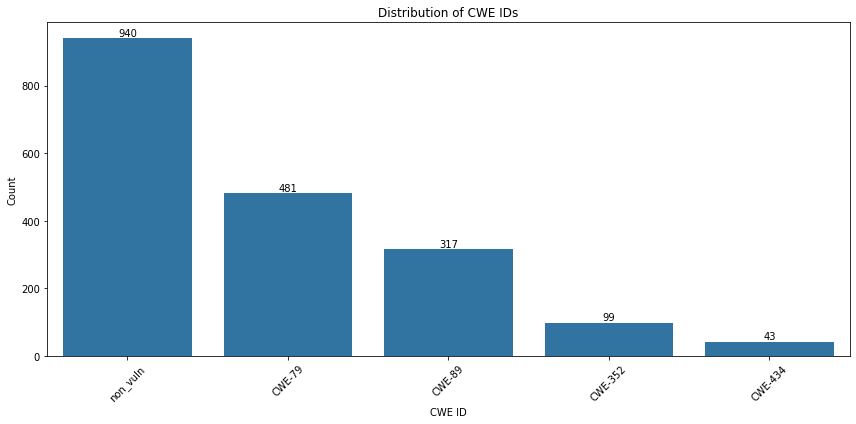

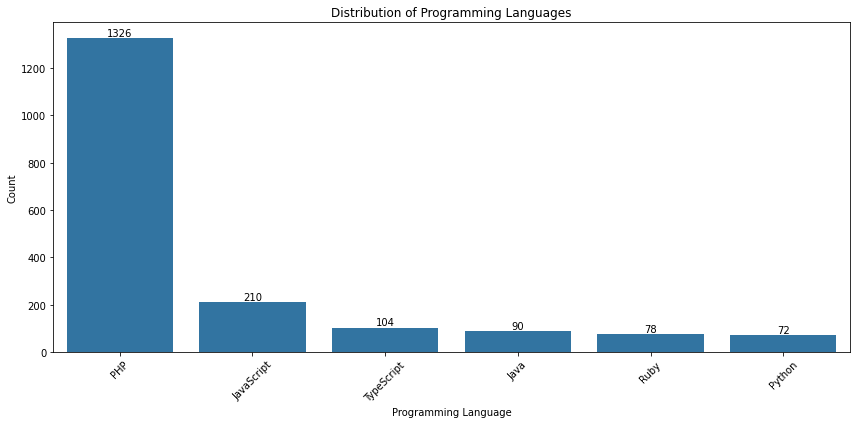

In [7]:
visualize_cwe_distribution(train_df, test=True)
visualize_language_distribution(train_df)

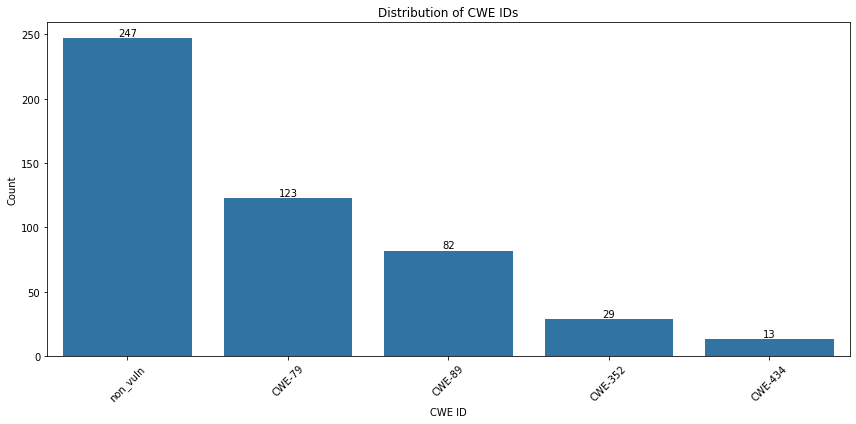

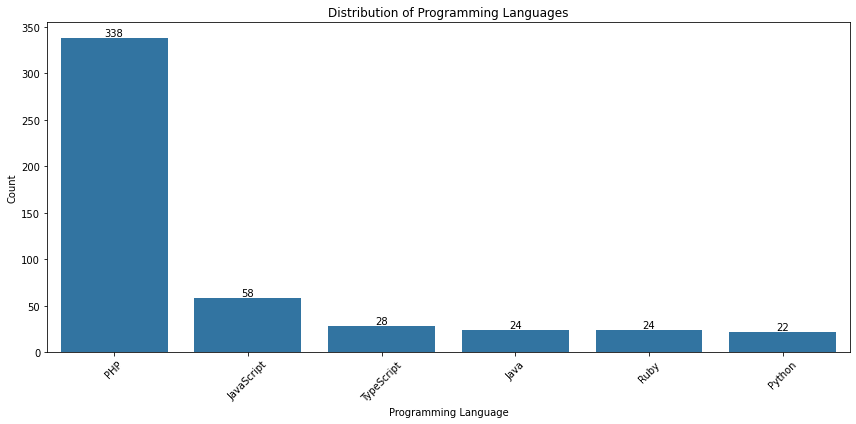

In [8]:
visualize_cwe_distribution(test_df, test=True)
visualize_language_distribution(test_df)

In [10]:
import random 

index = random.randint(0, len(train_df)-1)
print(index)
print(train_df['code'].iloc[index])
for elm in train_df['diff_deleted'].iloc[index]:
  print(elm)

1691
<?php

defined('GX_LIB') or die('Direct Access Not Allowed!');
/*
 * GeniXCMS - Content Management System
 *
 * PHP Based Content Management System and Framework
 *
 * @since 0.0.1 build date 20150312
 *
 * @version 1.0.0
 *
 * @link https://github.com/semplon/GeniXCMS
 * @link http://genixcms.org
 *
 * @author Puguh Wijayanto <psw@metalgenix.com>
 * @copyright 2014-2016 Puguh Wijayanto
 * @license http://www.opensource.org/licenses/mit-license.php MIT
 */

if (User::access(0)) {
    if (isset($_GET['view']) && $_GET['view'] == 'options') {
        $theme = Options::v('themes');
        $data['sitetitle'] = Theme::title($theme);
        Theme::admin('header', $data);
        Theme::options($theme);
        Theme::admin('footer');
    } else {
        if (isset($_POST['upload'])) {
            if (!Token::isExist($_POST['token'])) {
                $alertDanger[] = TOKEN_NOT_EXIST;
            }
            if (!isset($_FILES['theme']['name']) || $_FILES['theme']['name'] == '') {
 

In [12]:
train_df.to_pickle("../dataset/train_df.pkl")
test_df.to_pickle("../dataset/test_df.pkl")

In [13]:
train_df[train_df['programming_language'] == 'PHP'].to_pickle("../dataset/train_df_PHP.pkl")